In [1]:
cd ..

E:\18-09-19 Document structure\business\Study\Master\Cognitive Computing\P3\Machine learning in practice\git\Private\M5Forecast


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, gc
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, LeakyReLU
from tensorflow.keras.layers import Flatten, Input, BatchNormalization, Lambda
from tensorflow.keras.layers import Conv2D, MaxPooling2D, concatenate, Reshape, ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
os.environ['DATA_DIR'] = 'data/'
os.environ['SUB_DIR'] = 'submissions_uncertainty/'
for dirname, _, filenames in os.walk(os.environ['DATA_DIR']):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Hardcode requested quantiles
quantiles = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]

# Any results you write to the current directory are saved as output.


Bad key "text.kerning_factor" on line 4 in
E:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
def plot_loss(history):
    f, ax = plt.subplots(1, 1, figsize=(18, 6))
    ax.plot(history.history['loss'], label='Train')
    ax.plot(history.history['val_loss'], label='Validation')
    ax.set_ylim(0)
    ax.legend()
    plt.show()

# Pinball Loss function for Keras

In [4]:
train_df = pd.read_csv("custom_layer/features.csv", index_col=0)
target_df = pd.read_csv("custom_layer/targets.csv", index_col=0)

In [5]:
train_df.head()

,wday,month,snap_CA,w_1,w_2,w_3,w_4,w_5,w_6,w_7
date,,,,,,,,,,
2011-01-29,1,1,0,1,0,0,0,0,0,0
2011-01-30,2,1,0,0,1,0,0,0,0,0
2011-01-31,3,1,0,0,0,1,0,0,0,0
2011-02-01,4,2,1,0,0,0,1,0,0,0
2011-02-02,5,2,1,0,0,0,0,1,0,0


In [6]:
target_df.head()

,0.005,0.025,0.165,0.25,0.5,0.75,0.835,0.975,0.995
date,,,,,,,,,
2011-01-29,0.429084,0.500587,0.628482,0.662077,0.743227,0.824528,0.861499,0.989619,1.086067
2011-01-30,0.834881,1.032595,1.265410,1.343565,1.503276,1.660740,1.728179,2.014386,2.143587
2011-01-31,0.838167,0.991256,1.246369,1.329488,1.508577,1.680692,1.763780,1.976137,2.167394
2011-02-01,0.424697,0.501162,0.629065,0.668797,0.758173,0.842714,0.878296,1.015888,1.090475
2011-02-02,0.438830,0.511583,0.630601,0.669403,0.754088,0.842727,0.883785,1.007879,1.084537


In [7]:
def get_model(inp_shape, quantiles):
    # clear previous sessions
    K.clear_session()

    inp = Input(inp_shape, name="input")
    x = inp
    x = Dense(16)(x)
    x = Dense(32)(x)
    x = Dense(64)(x)
    x = Dense(2)(x)  # represents mu, sigma
    x = Dense(len(quantiles))(x)  # returns 9 points, one for each quantile
    out = x

    model = Model(inputs=inp, outputs=out)

    return model

In [8]:
quantiles = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]
model = get_model(inp_shape=(train_df.columns.size,), quantiles=quantiles)
model.compile(optimizer="adam", loss="MAE")
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 10)]              0         
_________________________________________________________________
dense (Dense)                (None, 16)                176       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 27        
Total params: 2,989
Trainable params: 2,989
Non-trainable params: 0
___________________________________________________________

In [9]:
X = train_df.values
y = target_df.values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
history = model.fit(X_train, y_train, epochs=300,
                    validation_data=(X_val, y_val))

Train on 269 samples, validate on 68 samples
Epoch 1/300
269/269 [==============================] - 2s 9ms/sample - loss: 1.0705 - val_loss: 0.9371
Epoch 2/300
269/269 [==============================] - 0s 750us/sample - loss: 0.9392 - val_loss: 0.8732
Epoch 3/300
269/269 [==============================] - 0s 102us/sample - loss: 0.9098 - val_loss: 0.8268
Epoch 4/300
269/269 [==============================] - 0s 102us/sample - loss: 0.8804 - val_loss: 0.8054
Epoch 5/300
269/269 [==============================] - 0s 99us/sample - loss: 0.8547 - val_loss: 0.7817
Epoch 6/300
269/269 [==============================] - 0s 100us/sample - loss: 0.8295 - val_loss: 0.7608
Epoch 7/300
269/269 [==============================] - 0s 106us/sample - loss: 0.8047 - val_loss: 0.7305
Epoch 8/300
269/269 [==============================] - 0s 104us/sample - loss: 0.7758 - val_loss: 0.7091
Epoch 9/300
269/269 [==============================] - 0s 102us/sample - loss: 0.7476 - val_loss: 0.6763
Epoch 10/300


269/269 [==============================] - 0s 173us/sample - loss: 0.0454 - val_loss: 0.0358
Epoch 79/300
269/269 [==============================] - 0s 125us/sample - loss: 0.0441 - val_loss: 0.0406
Epoch 80/300
269/269 [==============================] - 0s 102us/sample - loss: 0.0440 - val_loss: 0.0339
Epoch 81/300
269/269 [==============================] - 0s 97us/sample - loss: 0.0409 - val_loss: 0.0332
Epoch 82/300
269/269 [==============================] - 0s 100us/sample - loss: 0.0408 - val_loss: 0.0332
Epoch 83/300
269/269 [==============================] - 0s 97us/sample - loss: 0.0403 - val_loss: 0.0322
Epoch 84/300
269/269 [==============================] - 0s 102us/sample - loss: 0.0406 - val_loss: 0.0334
Epoch 85/300
269/269 [==============================] - 0s 105us/sample - loss: 0.0399 - val_loss: 0.0335
Epoch 86/300
269/269 [==============================] - 0s 102us/sample - loss: 0.0407 - val_loss: 0.0350
Epoch 87/300
269/269 [==============================] - 0s 10

269/269 [==============================] - 0s 117us/sample - loss: 0.0182 - val_loss: 0.0150
Epoch 156/300
269/269 [==============================] - 0s 100us/sample - loss: 0.0151 - val_loss: 0.0187
Epoch 157/300
269/269 [==============================] - 0s 117us/sample - loss: 0.0144 - val_loss: 0.0213
Epoch 158/300
269/269 [==============================] - 0s 95us/sample - loss: 0.0217 - val_loss: 0.0224
Epoch 159/300
269/269 [==============================] - 0s 97us/sample - loss: 0.0206 - val_loss: 0.0142
Epoch 160/300
269/269 [==============================] - 0s 99us/sample - loss: 0.0178 - val_loss: 0.0181
Epoch 161/300
269/269 [==============================] - 0s 104us/sample - loss: 0.0185 - val_loss: 0.0131
Epoch 162/300
269/269 [==============================] - 0s 111us/sample - loss: 0.0192 - val_loss: 0.0227
Epoch 163/300
269/269 [==============================] - 0s 108us/sample - loss: 0.0223 - val_loss: 0.0339
Epoch 164/300
269/269 [==============================]

Epoch 232/300
269/269 [==============================] - 0s 101us/sample - loss: 0.0191 - val_loss: 0.0165
Epoch 233/300
269/269 [==============================] - 0s 100us/sample - loss: 0.0164 - val_loss: 0.0183
Epoch 234/300
269/269 [==============================] - 0s 102us/sample - loss: 0.0160 - val_loss: 0.0145
Epoch 235/300
269/269 [==============================] - 0s 102us/sample - loss: 0.0140 - val_loss: 0.0145
Epoch 236/300
269/269 [==============================] - 0s 100us/sample - loss: 0.0126 - val_loss: 0.0111
Epoch 237/300
269/269 [==============================] - 0s 98us/sample - loss: 0.0128 - val_loss: 0.0147
Epoch 238/300
269/269 [==============================] - 0s 102us/sample - loss: 0.0151 - val_loss: 0.0126
Epoch 239/300
269/269 [==============================] - 0s 97us/sample - loss: 0.0140 - val_loss: 0.0116
Epoch 240/300
269/269 [==============================] - 0s 100us/sample - loss: 0.0116 - val_loss: 0.0108
Epoch 241/300
269/269 [================

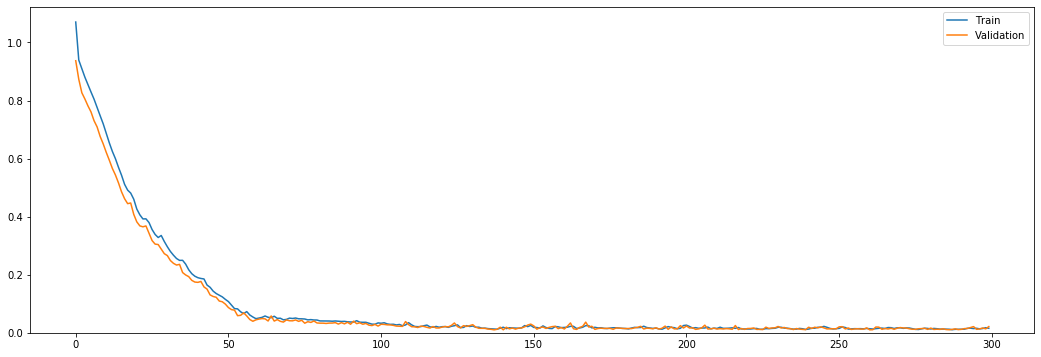

In [11]:
plot_loss(history)

In [12]:
y_pred = model.predict(X_val)

In [13]:
y_pred[0:2]

array([[0.4101884 , 0.478746  , 0.59686995, 0.65506124, 0.72547054,
        0.8169584 , 0.86430216, 0.97631246, 1.0609456 ],
       [0.85098755, 0.9993737 , 1.2375164 , 1.3175391 , 1.4837236 ,
        1.6506553 , 1.7293684 , 1.9692249 , 2.1158955 ]], dtype=float32)

## Rewrite to multi-output for each quantile

In [14]:
def get_model(inp_shape, quantiles):
    # clear previous sessions
    K.clear_session()

    inp = Input(inp_shape, name="input")
    x = inp
    x = Dense(16)(x)
    x = Dense(32)(x)
    x = Dense(64)(x)
    x = Dense(2)(x)  # represents mu, sigma
    
    #out_q0 = Dense(1, name="q0")(x)  # DistributionLayer(quantile=quantiles[0])(x)
    out_q0 = Dense(1, name="q0")(x)  # DistributionLayer(quantile=quantiles[0])(x)
    out_q1 = Dense(1, name="q1")(x)  # DistributionLayer(quantile=quantiles[0])(x)
    out_q2 = Dense(1, name="q2")(x)  # DistributionLayer(quantile=quantiles[0])(x)
    out_q3 = Dense(1, name="q3")(x)  # DistributionLayer(quantile=quantiles[0])(x)
    out_q4 = Dense(1, name="q4")(x)  # DistributionLayer(quantile=quantiles[0])(x)
    out_q5 = Dense(1, name="q5")(x)  # DistributionLayer(quantile=quantiles[0])(x)
    out_q6 = Dense(1, name="q6")(x)  # DistributionLayer(quantile=quantiles[0])(x)
    out_q7 = Dense(1, name="q7")(x)  # DistributionLayer(quantile=quantiles[0])(x)
    out_q8 = Dense(1, name="q8")(x)  # DistributionLayer(quantile=quantiles[0])(x)
    
#     out_q0 = DistributionLayer(quantiles[0],x)
#     out_q1 = DistributionLayer(quantiles[1],x)
#     out_q2 = DistributionLayer(quantiles[2],x)
#     out_q3 = DistributionLayer(quantiles[3],x)
#     out_q4 = DistributionLayer(quantiles[4],x)
#     out_q5 = DistributionLayer(quantiles[5],x)
#     out_q6 = DistributionLayer(quantiles[6],x)
#     out_q7 = DistributionLayer(quantiles[7],x)
#     out_q8 = DistributionLayer(quantiles[8],x)

    model = Model(inputs=inp, outputs=[out_q0, out_q1, out_q2, out_q3, out_q4, out_q5, out_q6, out_q7, out_q8])

    return model

In [15]:
model = get_model(inp_shape=(train_df.columns.size,), quantiles=quantiles)
model.compile(optimizer="adam", loss="MAE")
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 16)           176         input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           544         dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           2112        dense_1[0][0]                    
______________________________________________________________________________________________

In [16]:
y_train_mo = {'q'+str(i): y_train[:, i] for i in range(len(quantiles))}
y_val_mo = {'q'+str(i): y_val[:, i] for i in range(len(quantiles))}
y_train_mo

{'q0': array([0.77976871, 0.4255634 , 0.41740025, 0.42903284, 0.82754025,
        0.4064456 , 0.40616237, 0.45264247, 0.41096554, 0.41689168,
        0.38520678, 0.41300217, 0.40747019, 0.86864485, 0.43559714,
        0.42313449, 0.41549744, 0.43160425, 0.4241328 , 0.39397524,
        0.45516087, 0.92357664, 0.41138681, 0.4042906 , 0.84447597,
        0.42392267, 0.7718635 , 0.44973176, 0.43213789, 0.84063285,
        0.82372458, 0.78483486, 0.41210167, 0.43546165, 0.92956534,
        0.44674431, 0.40117869, 0.44582427, 0.83591121, 0.87259832,
        0.90353443, 0.42208748, 0.38899553, 0.45153601, 0.39837333,
        0.41525051, 0.42364229, 0.86586664, 0.40607733, 0.41816087,
        0.38255025, 0.89064516, 0.42218558, 0.42119283, 0.40201799,
        0.90192745, 0.40566299, 0.42338319, 0.41504695, 0.43416054,
        0.40994688, 0.41956467, 0.86222354, 0.40953107, 0.87499344,
        0.43268808, 0.40363463, 0.43650302, 0.41236164, 0.91755915,
        0.84431159, 0.79940419, 0.41597326

In [17]:
history = model.fit(X_train, y_train_mo, epochs=300,
                    validation_data=(X_val, y_val_mo))

Train on 269 samples, validate on 68 samples
Epoch 1/300
269/269 [==============================] - 3s 9ms/sample - loss: 8.8321 - q0_loss: 0.4345 - q1_loss: 0.6918 - q2_loss: 0.9457 - q3_loss: 1.0499 - q4_loss: 0.9108 - q5_loss: 0.7044 - q6_loss: 0.9783 - q7_loss: 1.4464 - q8_loss: 1.5584 - val_loss: 7.1725 - val_q0_loss: 0.2371 - val_q1_loss: 0.5503 - val_q2_loss: 0.3605 - val_q3_loss: 1.5631 - val_q4_loss: 0.8020 - val_q5_loss: 0.6186 - val_q6_loss: 0.9241 - val_q7_loss: 1.6932 - val_q8_loss: 0.5717
Epoch 2/300
269/269 [==============================] - 0s 175us/sample - loss: 6.7288 - q0_loss: 0.2636 - q1_loss: 0.3623 - q2_loss: 0.4209 - q3_loss: 0.8993 - q4_loss: 0.5300 - q5_loss: 0.6492 - q6_loss: 1.1235 - q7_loss: 1.7033 - q8_loss: 0.7830 - val_loss: 5.6954 - val_q0_loss: 0.2700 - val_q1_loss: 0.2695 - val_q2_loss: 0.4728 - val_q3_loss: 0.4006 - val_q4_loss: 0.3968 - val_q5_loss: 0.5506 - val_q6_loss: 0.8797 - val_q7_loss: 1.3433 - val_q8_loss: 0.9200
Epoch 3/300
269/269 [======

269/269 [==============================] - 0s 171us/sample - loss: 2.5472 - q0_loss: 0.0243 - q1_loss: 0.0138 - q2_loss: 0.0248 - q3_loss: 0.1950 - q4_loss: 0.0193 - q5_loss: 0.0293 - q6_loss: 0.8497 - q7_loss: 1.2455 - q8_loss: 0.1177 - val_loss: 2.2843 - val_q0_loss: 0.0252 - val_q1_loss: 0.0108 - val_q2_loss: 0.0140 - val_q3_loss: 0.1393 - val_q4_loss: 0.0145 - val_q5_loss: 0.0262 - val_q6_loss: 0.7257 - val_q7_loss: 1.0859 - val_q8_loss: 0.0881
Epoch 19/300
269/269 [==============================] - 0s 178us/sample - loss: 2.4592 - q0_loss: 0.0245 - q1_loss: 0.0154 - q2_loss: 0.0283 - q3_loss: 0.1661 - q4_loss: 0.0176 - q5_loss: 0.0383 - q6_loss: 0.8363 - q7_loss: 1.2292 - q8_loss: 0.0984 - val_loss: 2.2986 - val_q0_loss: 0.0244 - val_q1_loss: 0.0237 - val_q2_loss: 0.0118 - val_q3_loss: 0.0766 - val_q4_loss: 0.0529 - val_q5_loss: 0.0900 - val_q6_loss: 0.7774 - val_q7_loss: 1.0498 - val_q8_loss: 0.0411
Epoch 20/300
269/269 [==============================] - 0s 180us/sample - loss: 2

Epoch 36/300
269/269 [==============================] - 0s 184us/sample - loss: 1.4031 - q0_loss: 0.0241 - q1_loss: 0.0232 - q2_loss: 0.0395 - q3_loss: 0.0723 - q4_loss: 0.0229 - q5_loss: 0.0436 - q6_loss: 0.2847 - q7_loss: 0.8005 - q8_loss: 0.0718 - val_loss: 1.2394 - val_q0_loss: 0.0255 - val_q1_loss: 0.0172 - val_q2_loss: 0.0384 - val_q3_loss: 0.0527 - val_q4_loss: 0.0102 - val_q5_loss: 0.0367 - val_q6_loss: 0.2446 - val_q7_loss: 0.6587 - val_q8_loss: 0.0762
Epoch 37/300
269/269 [==============================] - 0s 177us/sample - loss: 1.3184 - q0_loss: 0.0265 - q1_loss: 0.0214 - q2_loss: 0.0278 - q3_loss: 0.0817 - q4_loss: 0.0262 - q5_loss: 0.0440 - q6_loss: 0.2612 - q7_loss: 0.7802 - q8_loss: 0.0526 - val_loss: 1.1247 - val_q0_loss: 0.0214 - val_q1_loss: 0.0124 - val_q2_loss: 0.0249 - val_q3_loss: 0.0391 - val_q4_loss: 0.0157 - val_q5_loss: 0.0443 - val_q6_loss: 0.1661 - val_q7_loss: 0.6551 - val_q8_loss: 0.0393
Epoch 38/300
269/269 [==============================] - 0s 199us/sam

Epoch 54/300
269/269 [==============================] - 0s 190us/sample - loss: 0.6833 - q0_loss: 0.0210 - q1_loss: 0.0135 - q2_loss: 0.0200 - q3_loss: 0.0883 - q4_loss: 0.0204 - q5_loss: 0.0503 - q6_loss: 0.1197 - q7_loss: 0.3055 - q8_loss: 0.0433 - val_loss: 0.5922 - val_q0_loss: 0.0156 - val_q1_loss: 0.0139 - val_q2_loss: 0.0250 - val_q3_loss: 0.0701 - val_q4_loss: 0.0214 - val_q5_loss: 0.0490 - val_q6_loss: 0.0705 - val_q7_loss: 0.2020 - val_q8_loss: 0.0570
Epoch 55/300
269/269 [==============================] - 0s 172us/sample - loss: 0.6687 - q0_loss: 0.0211 - q1_loss: 0.0152 - q2_loss: 0.0223 - q3_loss: 0.0805 - q4_loss: 0.0222 - q5_loss: 0.0535 - q6_loss: 0.1277 - q7_loss: 0.2704 - q8_loss: 0.0467 - val_loss: 0.5825 - val_q0_loss: 0.0202 - val_q1_loss: 0.0146 - val_q2_loss: 0.0144 - val_q3_loss: 0.0678 - val_q4_loss: 0.0297 - val_q5_loss: 0.0545 - val_q6_loss: 0.0811 - val_q7_loss: 0.1857 - val_q8_loss: 0.0338
Epoch 56/300
269/269 [==============================] - 0s 175us/sam

Epoch 72/300
269/269 [==============================] - 0s 167us/sample - loss: 0.4368 - q0_loss: 0.0188 - q1_loss: 0.0121 - q2_loss: 0.0180 - q3_loss: 0.0595 - q4_loss: 0.0123 - q5_loss: 0.0359 - q6_loss: 0.1062 - q7_loss: 0.1353 - q8_loss: 0.0376 - val_loss: 0.3753 - val_q0_loss: 0.0180 - val_q1_loss: 0.0124 - val_q2_loss: 0.0226 - val_q3_loss: 0.0593 - val_q4_loss: 0.0097 - val_q5_loss: 0.0281 - val_q6_loss: 0.0577 - val_q7_loss: 0.0886 - val_q8_loss: 0.0506
Epoch 73/300
269/269 [==============================] - 0s 178us/sample - loss: 0.4395 - q0_loss: 0.0194 - q1_loss: 0.0126 - q2_loss: 0.0196 - q3_loss: 0.0631 - q4_loss: 0.0140 - q5_loss: 0.0340 - q6_loss: 0.1024 - q7_loss: 0.1341 - q8_loss: 0.0362 - val_loss: 0.3321 - val_q0_loss: 0.0179 - val_q1_loss: 0.0136 - val_q2_loss: 0.0117 - val_q3_loss: 0.0515 - val_q4_loss: 0.0125 - val_q5_loss: 0.0178 - val_q6_loss: 0.0639 - val_q7_loss: 0.0776 - val_q8_loss: 0.0258
Epoch 74/300
269/269 [==============================] - 0s 169us/sam

Epoch 90/300
269/269 [==============================] - 0s 174us/sample - loss: 0.3878 - q0_loss: 0.0191 - q1_loss: 0.0129 - q2_loss: 0.0202 - q3_loss: 0.0438 - q4_loss: 0.0125 - q5_loss: 0.0266 - q6_loss: 0.0886 - q7_loss: 0.1192 - q8_loss: 0.0399 - val_loss: 0.2990 - val_q0_loss: 0.0180 - val_q1_loss: 0.0108 - val_q2_loss: 0.0145 - val_q3_loss: 0.0258 - val_q4_loss: 0.0070 - val_q5_loss: 0.0196 - val_q6_loss: 0.0612 - val_q7_loss: 0.0717 - val_q8_loss: 0.0320
Epoch 91/300
269/269 [==============================] - 0s 167us/sample - loss: 0.3545 - q0_loss: 0.0189 - q1_loss: 0.0116 - q2_loss: 0.0129 - q3_loss: 0.0415 - q4_loss: 0.0110 - q5_loss: 0.0245 - q6_loss: 0.0841 - q7_loss: 0.1144 - q8_loss: 0.0303 - val_loss: 0.3153 - val_q0_loss: 0.0166 - val_q1_loss: 0.0111 - val_q2_loss: 0.0182 - val_q3_loss: 0.0483 - val_q4_loss: 0.0090 - val_q5_loss: 0.0279 - val_q6_loss: 0.0502 - val_q7_loss: 0.0797 - val_q8_loss: 0.0350
Epoch 92/300
269/269 [==============================] - 0s 167us/sam

Epoch 108/300
269/269 [==============================] - 0s 169us/sample - loss: 0.3728 - q0_loss: 0.0196 - q1_loss: 0.0139 - q2_loss: 0.0278 - q3_loss: 0.0339 - q4_loss: 0.0155 - q5_loss: 0.0344 - q6_loss: 0.0681 - q7_loss: 0.0977 - q8_loss: 0.0525 - val_loss: 0.3132 - val_q0_loss: 0.0247 - val_q1_loss: 0.0189 - val_q2_loss: 0.0147 - val_q3_loss: 0.0282 - val_q4_loss: 0.0229 - val_q5_loss: 0.0375 - val_q6_loss: 0.0609 - val_q7_loss: 0.0804 - val_q8_loss: 0.0277
Epoch 109/300
269/269 [==============================] - 0s 174us/sample - loss: 0.3711 - q0_loss: 0.0225 - q1_loss: 0.0194 - q2_loss: 0.0245 - q3_loss: 0.0302 - q4_loss: 0.0240 - q5_loss: 0.0288 - q6_loss: 0.0656 - q7_loss: 0.1057 - q8_loss: 0.0462 - val_loss: 0.3462 - val_q0_loss: 0.0257 - val_q1_loss: 0.0215 - val_q2_loss: 0.0097 - val_q3_loss: 0.0312 - val_q4_loss: 0.0296 - val_q5_loss: 0.0538 - val_q6_loss: 0.0710 - val_q7_loss: 0.0744 - val_q8_loss: 0.0224
Epoch 110/300
269/269 [==============================] - 0s 167us/

Epoch 126/300
269/269 [==============================] - 0s 165us/sample - loss: 0.3841 - q0_loss: 0.0250 - q1_loss: 0.0192 - q2_loss: 0.0104 - q3_loss: 0.0558 - q4_loss: 0.0339 - q5_loss: 0.0673 - q6_loss: 0.0601 - q7_loss: 0.0823 - q8_loss: 0.0265 - val_loss: 0.3250 - val_q0_loss: 0.0202 - val_q1_loss: 0.0140 - val_q2_loss: 0.0104 - val_q3_loss: 0.0436 - val_q4_loss: 0.0247 - val_q5_loss: 0.0496 - val_q6_loss: 0.0469 - val_q7_loss: 0.0515 - val_q8_loss: 0.0266
Epoch 127/300
269/269 [==============================] - 0s 169us/sample - loss: 0.2989 - q0_loss: 0.0215 - q1_loss: 0.0146 - q2_loss: 0.0117 - q3_loss: 0.0361 - q4_loss: 0.0211 - q5_loss: 0.0412 - q6_loss: 0.0441 - q7_loss: 0.0774 - q8_loss: 0.0287 - val_loss: 0.2614 - val_q0_loss: 0.0183 - val_q1_loss: 0.0114 - val_q2_loss: 0.0117 - val_q3_loss: 0.0291 - val_q4_loss: 0.0207 - val_q5_loss: 0.0344 - val_q6_loss: 0.0416 - val_q7_loss: 0.0459 - val_q8_loss: 0.0213
Epoch 128/300
269/269 [==============================] - 0s 171us/

Epoch 144/300
269/269 [==============================] - 0s 169us/sample - loss: 0.2566 - q0_loss: 0.0225 - q1_loss: 0.0175 - q2_loss: 0.0160 - q3_loss: 0.0247 - q4_loss: 0.0217 - q5_loss: 0.0291 - q6_loss: 0.0291 - q7_loss: 0.0607 - q8_loss: 0.0351 - val_loss: 0.2394 - val_q0_loss: 0.0180 - val_q1_loss: 0.0104 - val_q2_loss: 0.0235 - val_q3_loss: 0.0257 - val_q4_loss: 0.0084 - val_q5_loss: 0.0298 - val_q6_loss: 0.0351 - val_q7_loss: 0.0320 - val_q8_loss: 0.0441
Epoch 145/300
269/269 [==============================] - 0s 171us/sample - loss: 0.2310 - q0_loss: 0.0189 - q1_loss: 0.0115 - q2_loss: 0.0142 - q3_loss: 0.0259 - q4_loss: 0.0129 - q5_loss: 0.0317 - q6_loss: 0.0271 - q7_loss: 0.0555 - q8_loss: 0.0338 - val_loss: 0.3032 - val_q0_loss: 0.0187 - val_q1_loss: 0.0105 - val_q2_loss: 0.0284 - val_q3_loss: 0.0409 - val_q4_loss: 0.0143 - val_q5_loss: 0.0498 - val_q6_loss: 0.0455 - val_q7_loss: 0.0310 - val_q8_loss: 0.0541
Epoch 146/300
269/269 [==============================] - 0s 167us/

Epoch 162/300
269/269 [==============================] - 0s 194us/sample - loss: 0.3331 - q0_loss: 0.0253 - q1_loss: 0.0184 - q2_loss: 0.0113 - q3_loss: 0.0553 - q4_loss: 0.0339 - q5_loss: 0.0680 - q6_loss: 0.0585 - q7_loss: 0.0324 - q8_loss: 0.0290 - val_loss: 0.2951 - val_q0_loss: 0.0189 - val_q1_loss: 0.0186 - val_q2_loss: 0.0083 - val_q3_loss: 0.0476 - val_q4_loss: 0.0287 - val_q5_loss: 0.0601 - val_q6_loss: 0.0470 - val_q7_loss: 0.0261 - val_q8_loss: 0.0240
Epoch 163/300
269/269 [==============================] - 0s 177us/sample - loss: 0.2897 - q0_loss: 0.0234 - q1_loss: 0.0176 - q2_loss: 0.0143 - q3_loss: 0.0413 - q4_loss: 0.0269 - q5_loss: 0.0513 - q6_loss: 0.0440 - q7_loss: 0.0316 - q8_loss: 0.0341 - val_loss: 0.3612 - val_q0_loss: 0.0289 - val_q1_loss: 0.0241 - val_q2_loss: 0.0089 - val_q3_loss: 0.0622 - val_q4_loss: 0.0383 - val_q5_loss: 0.0767 - val_q6_loss: 0.0673 - val_q7_loss: 0.0355 - val_q8_loss: 0.0214
Epoch 164/300
269/269 [==============================] - 0s 167us/

Epoch 180/300
269/269 [==============================] - 0s 175us/sample - loss: 0.1595 - q0_loss: 0.0187 - q1_loss: 0.0130 - q2_loss: 0.0160 - q3_loss: 0.0120 - q4_loss: 0.0109 - q5_loss: 0.0146 - q6_loss: 0.0133 - q7_loss: 0.0239 - q8_loss: 0.0361 - val_loss: 0.1624 - val_q0_loss: 0.0200 - val_q1_loss: 0.0151 - val_q2_loss: 0.0172 - val_q3_loss: 0.0080 - val_q4_loss: 0.0131 - val_q5_loss: 0.0103 - val_q6_loss: 0.0103 - val_q7_loss: 0.0271 - val_q8_loss: 0.0309
Epoch 181/300
269/269 [==============================] - 0s 171us/sample - loss: 0.1677 - q0_loss: 0.0193 - q1_loss: 0.0132 - q2_loss: 0.0171 - q3_loss: 0.0150 - q4_loss: 0.0134 - q5_loss: 0.0171 - q6_loss: 0.0152 - q7_loss: 0.0251 - q8_loss: 0.0343 - val_loss: 0.2126 - val_q0_loss: 0.0150 - val_q1_loss: 0.0138 - val_q2_loss: 0.0273 - val_q3_loss: 0.0164 - val_q4_loss: 0.0124 - val_q5_loss: 0.0205 - val_q6_loss: 0.0167 - val_q7_loss: 0.0258 - val_q8_loss: 0.0512
Epoch 182/300
269/269 [==============================] - 0s 174us/

Epoch 198/300
269/269 [==============================] - 0s 171us/sample - loss: 0.1727 - q0_loss: 0.0196 - q1_loss: 0.0132 - q2_loss: 0.0139 - q3_loss: 0.0172 - q4_loss: 0.0144 - q5_loss: 0.0204 - q6_loss: 0.0186 - q7_loss: 0.0226 - q8_loss: 0.0324 - val_loss: 0.1618 - val_q0_loss: 0.0200 - val_q1_loss: 0.0164 - val_q2_loss: 0.0144 - val_q3_loss: 0.0152 - val_q4_loss: 0.0147 - val_q5_loss: 0.0179 - val_q6_loss: 0.0174 - val_q7_loss: 0.0251 - val_q8_loss: 0.0301
Epoch 199/300
269/269 [==============================] - 0s 175us/sample - loss: 0.1861 - q0_loss: 0.0190 - q1_loss: 0.0133 - q2_loss: 0.0219 - q3_loss: 0.0174 - q4_loss: 0.0101 - q5_loss: 0.0215 - q6_loss: 0.0152 - q7_loss: 0.0271 - q8_loss: 0.0436 - val_loss: 0.1905 - val_q0_loss: 0.0179 - val_q1_loss: 0.0116 - val_q2_loss: 0.0231 - val_q3_loss: 0.0157 - val_q4_loss: 0.0120 - val_q5_loss: 0.0188 - val_q6_loss: 0.0154 - val_q7_loss: 0.0263 - val_q8_loss: 0.0415
Epoch 200/300
269/269 [==============================] - 0s 177us/

Epoch 216/300
269/269 [==============================] - 0s 171us/sample - loss: 0.1302 - q0_loss: 0.0183 - q1_loss: 0.0106 - q2_loss: 0.0084 - q3_loss: 0.0137 - q4_loss: 0.0079 - q5_loss: 0.0170 - q6_loss: 0.0137 - q7_loss: 0.0138 - q8_loss: 0.0247 - val_loss: 0.1271 - val_q0_loss: 0.0168 - val_q1_loss: 0.0110 - val_q2_loss: 0.0108 - val_q3_loss: 0.0130 - val_q4_loss: 0.0075 - val_q5_loss: 0.0156 - val_q6_loss: 0.0130 - val_q7_loss: 0.0138 - val_q8_loss: 0.0200
Epoch 217/300
269/269 [==============================] - 0s 171us/sample - loss: 0.1280 - q0_loss: 0.0191 - q1_loss: 0.0118 - q2_loss: 0.0103 - q3_loss: 0.0116 - q4_loss: 0.0088 - q5_loss: 0.0133 - q6_loss: 0.0115 - q7_loss: 0.0159 - q8_loss: 0.0262 - val_loss: 0.1294 - val_q0_loss: 0.0195 - val_q1_loss: 0.0154 - val_q2_loss: 0.0140 - val_q3_loss: 0.0092 - val_q4_loss: 0.0102 - val_q5_loss: 0.0106 - val_q6_loss: 0.0123 - val_q7_loss: 0.0209 - val_q8_loss: 0.0287
Epoch 218/300
269/269 [==============================] - 0s 173us/

Epoch 234/300
269/269 [==============================] - 0s 177us/sample - loss: 0.1869 - q0_loss: 0.0198 - q1_loss: 0.0136 - q2_loss: 0.0136 - q3_loss: 0.0226 - q4_loss: 0.0167 - q5_loss: 0.0275 - q6_loss: 0.0239 - q7_loss: 0.0214 - q8_loss: 0.0291 - val_loss: 0.1887 - val_q0_loss: 0.0204 - val_q1_loss: 0.0172 - val_q2_loss: 0.0209 - val_q3_loss: 0.0160 - val_q4_loss: 0.0165 - val_q5_loss: 0.0210 - val_q6_loss: 0.0198 - val_q7_loss: 0.0304 - val_q8_loss: 0.0417
Epoch 235/300
269/269 [==============================] - 0s 175us/sample - loss: 0.1919 - q0_loss: 0.0204 - q1_loss: 0.0165 - q2_loss: 0.0171 - q3_loss: 0.0174 - q4_loss: 0.0166 - q5_loss: 0.0213 - q6_loss: 0.0206 - q7_loss: 0.0260 - q8_loss: 0.0347 - val_loss: 0.1795 - val_q0_loss: 0.0211 - val_q1_loss: 0.0149 - val_q2_loss: 0.0116 - val_q3_loss: 0.0248 - val_q4_loss: 0.0161 - val_q5_loss: 0.0315 - val_q6_loss: 0.0264 - val_q7_loss: 0.0155 - val_q8_loss: 0.0194
Epoch 236/300
269/269 [==============================] - 0s 173us/

Epoch 252/300
269/269 [==============================] - 0s 169us/sample - loss: 0.1636 - q0_loss: 0.0190 - q1_loss: 0.0136 - q2_loss: 0.0180 - q3_loss: 0.0121 - q4_loss: 0.0109 - q5_loss: 0.0146 - q6_loss: 0.0117 - q7_loss: 0.0258 - q8_loss: 0.0385 - val_loss: 0.1128 - val_q0_loss: 0.0193 - val_q1_loss: 0.0131 - val_q2_loss: 0.0094 - val_q3_loss: 0.0109 - val_q4_loss: 0.0084 - val_q5_loss: 0.0116 - val_q6_loss: 0.0121 - val_q7_loss: 0.0144 - val_q8_loss: 0.0195
Epoch 253/300
269/269 [==============================] - 0s 177us/sample - loss: 0.1485 - q0_loss: 0.0194 - q1_loss: 0.0126 - q2_loss: 0.0166 - q3_loss: 0.0092 - q4_loss: 0.0096 - q5_loss: 0.0100 - q6_loss: 0.0092 - q7_loss: 0.0238 - q8_loss: 0.0355 - val_loss: 0.1480 - val_q0_loss: 0.0211 - val_q1_loss: 0.0166 - val_q2_loss: 0.0171 - val_q3_loss: 0.0099 - val_q4_loss: 0.0139 - val_q5_loss: 0.0114 - val_q6_loss: 0.0132 - val_q7_loss: 0.0246 - val_q8_loss: 0.0325
Epoch 254/300
269/269 [==============================] - 0s 177us/

Epoch 270/300
269/269 [==============================] - 0s 169us/sample - loss: 0.1913 - q0_loss: 0.0198 - q1_loss: 0.0125 - q2_loss: 0.0170 - q3_loss: 0.0225 - q4_loss: 0.0123 - q5_loss: 0.0284 - q6_loss: 0.0217 - q7_loss: 0.0206 - q8_loss: 0.0344 - val_loss: 0.2110 - val_q0_loss: 0.0175 - val_q1_loss: 0.0111 - val_q2_loss: 0.0247 - val_q3_loss: 0.0249 - val_q4_loss: 0.0064 - val_q5_loss: 0.0313 - val_q6_loss: 0.0215 - val_q7_loss: 0.0277 - val_q8_loss: 0.0455
Epoch 271/300
269/269 [==============================] - 0s 175us/sample - loss: 0.1927 - q0_loss: 0.0210 - q1_loss: 0.0150 - q2_loss: 0.0169 - q3_loss: 0.0212 - q4_loss: 0.0152 - q5_loss: 0.0263 - q6_loss: 0.0230 - q7_loss: 0.0254 - q8_loss: 0.0337 - val_loss: 0.2251 - val_q0_loss: 0.0246 - val_q1_loss: 0.0188 - val_q2_loss: 0.0097 - val_q3_loss: 0.0400 - val_q4_loss: 0.0241 - val_q5_loss: 0.0509 - val_q6_loss: 0.0431 - val_q7_loss: 0.0155 - val_q8_loss: 0.0238
Epoch 272/300
269/269 [==============================] - 0s 171us/

Epoch 288/300
269/269 [==============================] - 0s 169us/sample - loss: 0.1150 - q0_loss: 0.0181 - q1_loss: 0.0108 - q2_loss: 0.0091 - q3_loss: 0.0099 - q4_loss: 0.0068 - q5_loss: 0.0117 - q6_loss: 0.0103 - q7_loss: 0.0147 - q8_loss: 0.0247 - val_loss: 0.1354 - val_q0_loss: 0.0200 - val_q1_loss: 0.0138 - val_q2_loss: 0.0095 - val_q3_loss: 0.0136 - val_q4_loss: 0.0111 - val_q5_loss: 0.0161 - val_q6_loss: 0.0152 - val_q7_loss: 0.0149 - val_q8_loss: 0.0209
Epoch 289/300
269/269 [==============================] - 0s 171us/sample - loss: 0.1254 - q0_loss: 0.0196 - q1_loss: 0.0110 - q2_loss: 0.0077 - q3_loss: 0.0129 - q4_loss: 0.0096 - q5_loss: 0.0150 - q6_loss: 0.0133 - q7_loss: 0.0139 - q8_loss: 0.0226 - val_loss: 0.1268 - val_q0_loss: 0.0169 - val_q1_loss: 0.0119 - val_q2_loss: 0.0070 - val_q3_loss: 0.0138 - val_q4_loss: 0.0087 - val_q5_loss: 0.0174 - val_q6_loss: 0.0158 - val_q7_loss: 0.0116 - val_q8_loss: 0.0193
Epoch 290/300
269/269 [==============================] - 0s 177us/

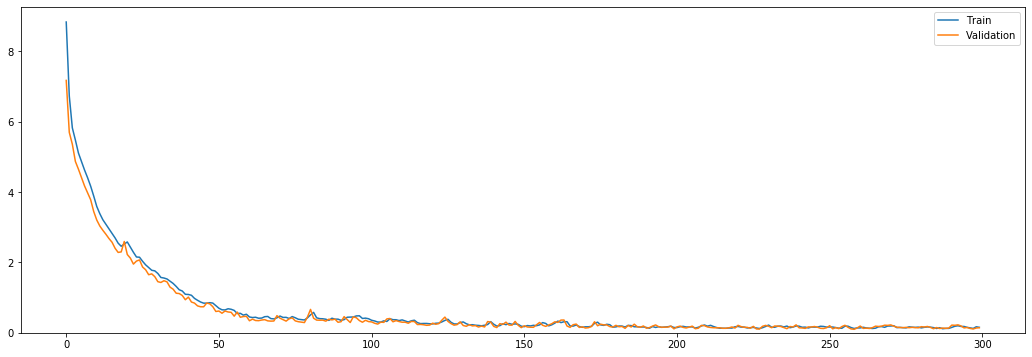

In [18]:
plot_loss(history)

In [19]:
y_pred = model.predict(X_val)

# revert multi output format to (n_samples, quantiles)
y_pred = np.array(list(zip(*y_pred))).squeeze()
y_pred[0:2]

array([[0.4129757 , 0.4880843 , 0.6146252 , 0.646021  , 0.7335391 ,
        0.8156561 , 0.85565615, 0.9854189 , 1.0627505 ],
       [0.8513606 , 1.003415  , 1.243402  , 1.3182895 , 1.485189  ,
        1.6518749 , 1.7270449 , 1.973032  , 2.114153  ]], dtype=float32)

**Note**: training seems slower! 

## Implement custom layer

In [32]:
# from https://www.wolframalpha.com/input/?i=percentiles+of+a+normal+distribution
sigma_coefs = [-2.57583, -1.95996, -0.974114, -0.674, 0, 0.674, 0.9741114, 1.95996, 2.57583]
import scipy

# Source:https://stats.stackexchange.com/questions/443334/numerical-approximation-to-quantile-function-for-gamma-distribution
# Source:http://wwwens.aero.jussieu.fr/lefrere/master/SPE/docs-python/scipy-doc/generated/scipy.special.gdtrix.html\
# takes quantile in range [0,1] or (0,1) or [0,1) or (0,1] # doubt
def get_custom_layer_skewed(quantile):
    def custom_layer(tensor):
        tensor1 = tensor[0] # The rate parameter Beta (float). It is also the reciprocal of the scale parameter theta.
        tensor2 = tensor[1] # The shape parameter Alpha of the gamma distribution, sometimes denoted  (float).
        print(f'quantile={quantile},beta={tensor1},alpha={tensor2}')
        print(f'returning={scipy.special.gdtrix(tensor1, tensor2, quantile, out=None)}')
        return scipy.special.gdtrix(tensor1, tensor2, quantile, out=None)

    return custom_layer

def get_dist_model(inp_shape, quantiles):
    # clear previous sessions
    K.clear_session()

    inp = Input(inp_shape, name="input")
    x = inp
    x = Dense(16)(x)
    x = Dense(32)(x)
    x = Dense(64)(x)

    beta = Dense(1)(x)  # represents beta
    alpha = Dense(1)(x)  # represents alpha

    outs = []

    for i, quantile in enumerate(quantiles):
        #custom_layer = get_custom_layer(sigma_coef=sigma_coef)
        custom_layer = get_custom_layer_skewed(quantile=quantile)
        out_q = Lambda(custom_layer, name="q{}".format(i))([beta, alpha])
        outs.append(out_q)

    model = Model(inputs=inp, outputs=outs) 

    return model

In [33]:
model = get_dist_model(inp_shape=(train_df.columns.size,), quantiles=quantiles)
model.compile(optimizer="adam", loss="MAE")
model.summary()

quantile=0.005,beta=Tensor("dense_3/Identity:0", shape=(None, 1), dtype=float32),alpha=Tensor("dense_4/Identity:0", shape=(None, 1), dtype=float32)


NotImplementedError: Cannot convert a symbolic Tensor (dense_3/Identity:0) to a numpy array.

In [ ]:
y_train_mo = {'q'+str(i): y_train[:, i] for i in range(len(quantiles))}
y_val_mo = {'q'+str(i): y_val[:, i] for i in range(len(quantiles))}
y_train_mo

In [ ]:
history = model.fit(X_train, y_train_mo, epochs=300,
                    validation_data=(X_val, y_val_mo))

In [ ]:
plot_loss(history)

In [ ]:
y_pred = model.predict(X_val)

# revert multi output format to (n_samples, quantiles)
y_pred = np.array(list(zip(*y_pred))).squeeze()
y_pred[0:2]

## Employ pinball loss

In [ ]:
# from Daniel Sch., at:
# https://stackoverflow.com/questions/43151694/define-pinball-loss-function-in-keras-with-tensorflow-backend
def create_pinball_loss(tau=0.5):
    def pinball_loss(y_true, y_pred):
        err = y_true - y_pred
        return K.mean(K.maximum(tau * err, (tau - 1) * err), axis=-1)
    return pinball_loss

In [ ]:
losses = {'q'+str(i): create_pinball_loss(tau=q) for (i, q) in enumerate(quantiles)}
losses

### With dense layers

In [ ]:
model = get_model(inp_shape=(train_df.columns.size,), quantiles=quantiles)
model.compile(optimizer="adam", loss=losses)
model.summary()

In [ ]:
history = model.fit(X_train, y_train_mo, epochs=300,
                    validation_data=(X_val, y_val_mo))

In [ ]:
plot_loss(history)

In [ ]:
# predict validation set
y_pred = model.predict(X_val)
# revert multi output format to (n_samples, quantiles)
y_pred = np.array(list(zip(*y_pred))).squeeze()
y_pred[0:2]

### With distribution layer

In [ ]:
model = get_dist_model(inp_shape=(train_df.columns.size,), sigma_coefs=sigma_coefs)
model.compile(optimizer="adam", loss=losses)
model.summary()

In [ ]:
history = model.fit(X_train, y_train_mo, epochs=300,
                    validation_data=(X_val, y_val_mo))

In [ ]:
plot_loss(history)

In [ ]:
# predict validation set
y_pred = model.predict(X_val)
# revert multi output format to (n_samples, quantiles)
y_pred = np.array(list(zip(*y_pred))).squeeze()
y_pred[0:2]

**Note**: the distribution of predictions is wider than when trained with the MAE. This is in line with what we would expect: over-predicting the lower quantiles is punished much harder than before, and the same for under-predicting the higher quantiles.

## Test pinball loss

In [ ]:
# from https://github.com/keras-team/keras/pull/8033/files
def test_pinball_loss():
    y_pred = K.variable(np.array([0.3, 0.6, 0.1]))
    y_true = K.variable(np.array([0.3, 0.4, 0.5]))
    quantile = 0.25
    loss_fcn = create_pinball_loss(tau=quantile)#losses.PinballLoss(quantile)
    expected_loss = (quantile * 0.4 + (1 - quantile) * 0.2) / 3
    loss = K.eval(loss_fcn(y_true, y_pred))
    assert np.isclose(expected_loss, loss)

test_pinball_loss()

## Dataset 2

In [ ]:
train_df = pd.read_csv("custom_layer/features2.csv", index_col=0)
target_df = pd.read_csv("custom_layer/targets2.csv", index_col=0, header=None, names=['target'])
quantiles = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]

In [ ]:
train_df.head()

In [ ]:
target_df.head()

In [ ]:
# from Daniel Sch., at:
# https://stackoverflow.com/questions/43151694/define-pinball-loss-function-in-keras-with-tensorflow-backend
def create_pinball_loss(tau=0.5):
    def pinball_loss(y_true, y_pred):
        err = y_true - y_pred
        return K.mean(K.maximum(tau * err, (tau - 1) * err), axis=-1)
    return pinball_loss

In [ ]:
X = train_df.values
y = target_df.values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

y_train_mo = {'q'+str(i): y_train for i in range(len(quantiles))}
y_val_mo = {'q'+str(i): y_val for i in range(len(quantiles))}

In [ ]:
losses = {'q'+str(i): create_pinball_loss(tau=q) for (i, q) in enumerate(quantiles)}
losses

### With dense layers

In [ ]:
def get_model(inp_shape, quantiles):
    # clear previous sessions
    K.clear_session()

    inp = Input(inp_shape, name="input")
    x = inp
    x = Dense(16)(x)
    x = Dense(32)(x)
    x = Dense(64)(x)
    x = Dense(2)(x)  # represents mu, sigma
    
    out_q0 = Dense(1, name="q0")(x)  # DistributionLayer(quantile=quantiles[0])(x)
    out_q1 = Dense(1, name="q1")(x)  # DistributionLayer(quantile=quantiles[1])(x)
    out_q2 = Dense(1, name="q2")(x)  # ...
    out_q3 = Dense(1, name="q3")(x)
    out_q4 = Dense(1, name="q4")(x)
    out_q5 = Dense(1, name="q5")(x)
    out_q6 = Dense(1, name="q6")(x)
    out_q7 = Dense(1, name="q7")(x)
    out_q8 = Dense(1, name="q8")(x)

    model = Model(inputs=inp, outputs=[out_q0, out_q1, out_q2, out_q3, out_q4, out_q5, out_q6, out_q7, out_q8])

    return model

In [ ]:
model = get_model(inp_shape=(X_train.shape[1],), quantiles=quantiles)
model.compile(optimizer="adam", loss=losses)
model.summary()

In [ ]:
history = model.fit(X_train, y_train_mo, epochs=300,
                    validation_data=(X_val, y_val_mo))

In [ ]:
plot_loss(history)

**Predicted distribution**

In [ ]:
# predict validation set
y_pred = model.predict(X_val)
# revert multi output format to (n_samples, quantiles)
y_pred = np.array(list(zip(*y_pred))).squeeze()
y_pred[0:2]

### With distribution layer

In [ ]:
model = get_dist_model(inp_shape=(X_train.shape[1],), sigma_coefs=sigma_coefs)
model.compile(optimizer="adam", loss=losses)
model.summary()

In [ ]:
history_dist = model.fit(X_train, y_train_mo, epochs=300,
                         validation_data=(X_val, y_val_mo))

In [ ]:
plot_loss(history_dist)

### Compare loss

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(18, 6))
start_step = 0

# ax.plot(history.history['loss'][start_step:], label="Train (dense)")
ax.plot(history.history['val_loss'][start_step:], label="Validation (dense)")
# ax.plot(history_dist.history['loss'][start_step:], label="Train (distibution layer)")
ax.plot(history_dist.history['val_loss'][start_step:], label="Validation (distibution layer)")
ax.legend()
plt.show()

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(18, 6))
start_step = 50

# ax.plot(history.history['loss'][start_step:], label="Train (dense)")
ax.plot(history.history['val_loss'][start_step:], label="Validation (dense)")
# ax.plot(history_dist.history['loss'][start_step:], label="Train (distibution layer)")
ax.plot(history_dist.history['val_loss'][start_step:], label="Validation (distibution layer)")
ax.legend()
plt.show()

In [ ]:
# "true" quantiles
pd.Series(np.random.normal(0.75, 0.13, size=100000)).quantile(quantiles)

In [ ]:
# "true" quantiles
pd.Series(np.random.normal(1.5, 0.25, size=100000)).quantile(quantiles)

**Result**: The toy dataset contains two simple distributions, with either $\mu=0.75, \sigma=0.13$ or $\mu=1.5, \sigma=0.25$, depending on whether it is a weekday or weekend. The observed 'demand' are samples distributed as such. For these simple distributions, the Pinball Loss is able to (approximately) retrieve the correct quantiles!